# Predicting 2022 NBA All Stars
**Authors**: Munachimso Ukwuoma, Eyob Ashagire, Solomon Osa

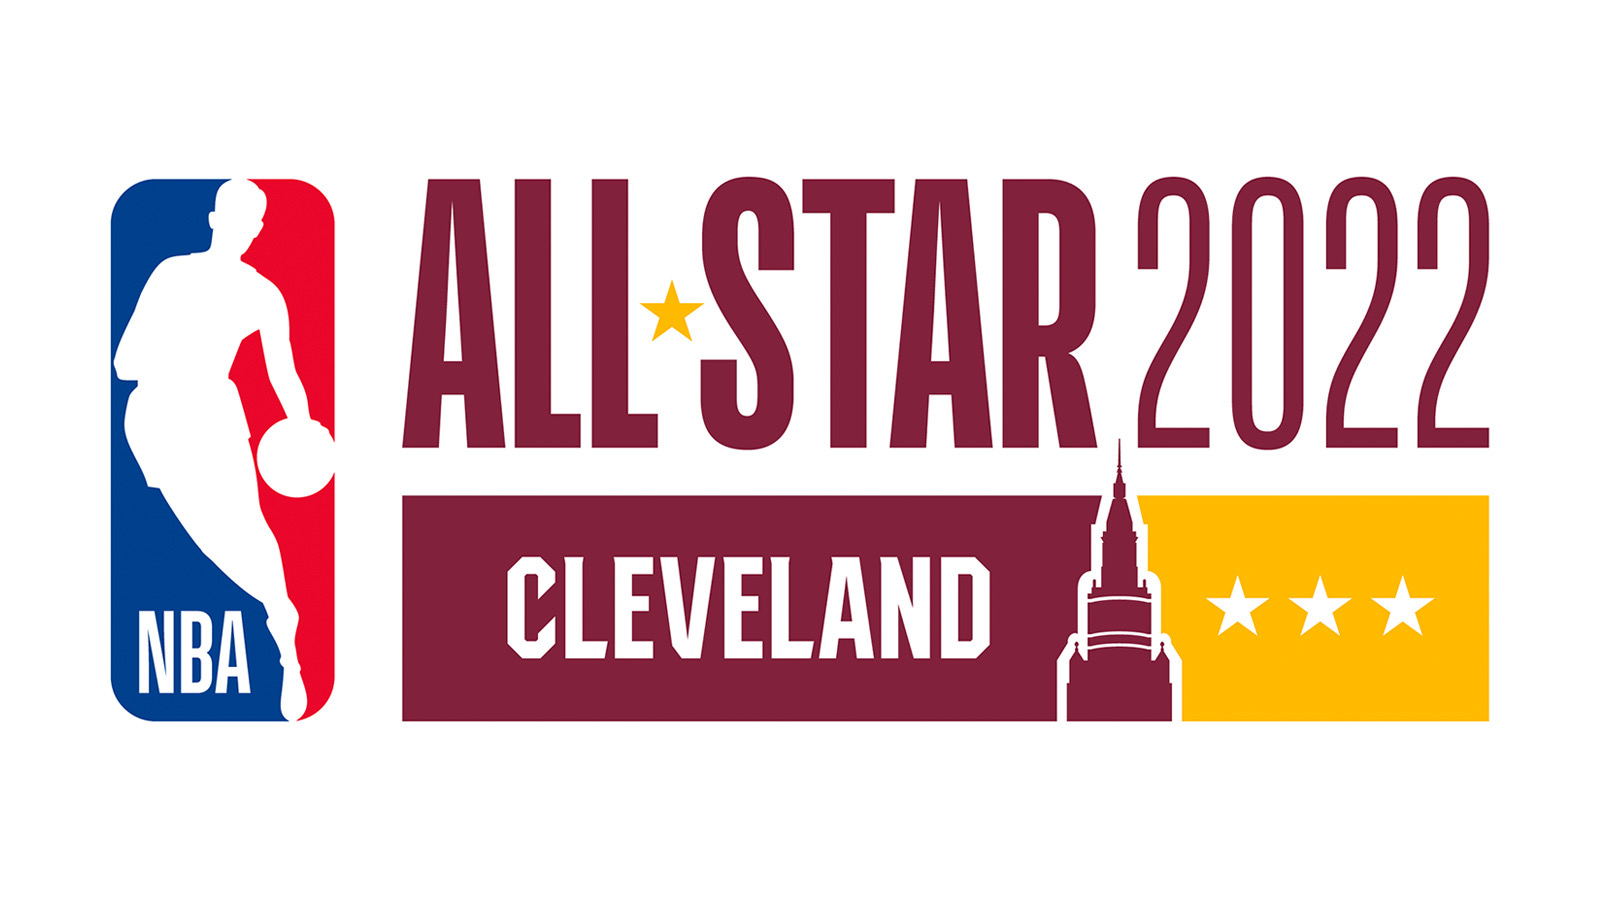

## Introduction

​​There are 30 **National Basektball Association** (NBA) teams. Those 30 teams are split into two conferences, Eastern and Western, and there are 15 players on each roster which obviously means there is a total of 450 players in the NBA. 82 regular season games are played by each team over the course of 6 months usually from late October to mid-April. During the course of a long season, the players do get a mid-season break. This break is known as the All-Star Break where *some* players get a break from Friday to the next Wednesday. During this All-Star Break, there is an 3 day event called NBA All-Star weekend which lasts from Friday to Sunday. The 3 day event is headlined by the All-Star Game, which is held on Sunday. Out the 450 players in the NBA, there are 24 players selected to play in the All-Star Game, 12 from each conference. The player selection process begins with fan voting, which is worth 50%, player voting worth 25%, and basketball media picking the starting 5 for each conference. The remaining 14 players are selected by the NBA coaches. Then the two leading vote getters are designated team captains and will then choose their respective teams. 

## Relevance
Every year, there is controversy selecting the NBA All-Stars. For example, in 2017 fringe(and nowhere near the All-Star level) Golden State Warriors Center Zaza Pachulia was nearly voted into the NBA All-Star game due to weight of the fan vote(80% at the time) and because the Warriors were the most popular team in the league at the time. In order to reduce bias, we think there should be an unbiased selective process for the All-Stars in order to reduce controversy. Analytics have become extremely prevalent in sports and in basketball it makes sense there is an analyltical way of selecting the All-Stars.

## How the project works

In the project, we start by scraping Basketball Reference data. This data includes the basic and advanced statistics of NBA players over the past ten years. Then we scraped the All-Stars of the past ten years. After scraping all the data, we use a correlation matrix to determine which statistics were the most important in becoming an All-Star and we build our predictive model using those statistics. Finally, we use logistic regression to better understand the relationship between the different variables by estimating probabilities. This type of analysis allows us to predict the liklihood of an event, which in our case is the 2022 NBA All Stars.

In [2]:
#!pip install lxml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sqlite3
import scipy.stats as stats
import requests
import sklearn
from bs4 import BeautifulSoup, SoupStrainer
from datetime import timedelta, datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from urllib.request import urlopen
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
import sys, os

This function scrapes data for All-Stars in any given year.

In [3]:
def scrape_all_stars(year):
    
    url = f'https://www.basketball-reference.com/allstar/NBA_{year}.html'
    html = urlopen(url)

    soup = BeautifulSoup(html, features = "lxml")

    rows = soup.findAll('tr')[6:]
    rows_data = [[td.getText() for td in rows[i].findAll('th')]
                        for i in range(len(rows))]

    arr = []
    for i in rows_data:
        if ((len(i) == 1) and (i[0] != 'Team Totals')):
            arr.append(i)

    df = pd.DataFrame(arr)
    
    df.columns= ["Player"]
    df["Year"] = year
    df["Player"] = pd.Series(df["Player"],dtype = "string")
    
    return df

This function scrapes Basketball Reference for basic stats in any given year.

In [4]:

def scrape_basic_stats(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html#per_game_stats"
    html = urlopen(url)

    soup = BeautifulSoup(html, features = "lxml")

    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

    rows = soup.findAll('tr')[0:]
    rows_data = [[td.getText() for td in rows[i].findAll('td')]
                        for i in range(len(rows))]

    df = pd.DataFrame(rows_data)
    #df = df.drop(columns=[28])
    df.columns = ["Player", "Pos", "Age", "Tm", "G", "GS", "MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
    df = df.dropna()
    
    df["Year"] = year
    pd.set_option("display.max_rows", 729, "display.max_columns", 30)
    
    df["Is All Star"] = 0
    
    df = df.drop_duplicates(subset=['Player'])
    df = df.reset_index()
    df = df.drop(columns = ["index"])
    
    y = df["Year"]
    p = df["Player"]
        
    for i in range(0, len(df.index)):
        if(year != 2022):
            if (p[i] in scrape_all_stars(y[i])["Player"].unique()):
                df.at[i, 'Is All Star'] = 1
            
    
        
    return df
    

This function scrapes Basketball Reference for advanced stats in any given year.

In [5]:
def scrape_advanced_stats(year):
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
    html = urlopen(url)

    soup = BeautifulSoup(html, features = "lxml")

    headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

    rows = soup.findAll('tr')[0:]
    rows_data = [[td.getText() for td in rows[i].findAll('td')]
                        for i in range(len(rows))]

    df = pd.DataFrame(rows_data)

    df = df.drop(columns=[18, 23])
    df.columns = ["Player", "Pos", "Age", "Tm", "G", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]
    
    df = df.drop_duplicates(subset=['Player'])
    df = df.drop(columns=["Player", "Pos", "Age", "Tm", "G", "MP"])

    df = df.dropna()
    df = df.reset_index()
    df = df.drop(columns = ["index"])
    
    return df

In this function we will scrape all data for the All Stars of the previous 10 years and merge them into one dataframe. 

In [7]:

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
arr = []
arr2 = []
arr3 = []
df_arr = []
final_df = []

for y in years:
    arr2.append(scrape_all_stars(y))
    arr.append(scrape_advanced_stats(y))
    arr3.append(scrape_basic_stats(y))
    
for i in range(0, len(years)):
    df_arr.append(pd.concat([arr3[i],arr[i]], axis = 1))
    
for i in range(0, len(years)):
    final_df.append(df_arr[i])
    
df = final_df[0]
for i in range (1, len(years)):
    df = pd.concat([final_df[i],df])
 
df = df.reset_index()
df = df.drop(columns = "index")
#pd.set_option("display.max_rows", 729, "display.max_columns", 50)
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,.544,0.0,0.0,.000,2.0,3.7,...,20.6,16.1,6.1,1.3,4.0,13.5,19.5,0.3,1.0,1.3,.085,-3.5,-0.9,-4.5,-0.5
1,Jaylen Adams,PG,24,MIL,7,0,2.6,0.1,1.1,.125,0.0,0.3,.000,0.1,0.9,...,16.9,8.8,12.7,0.0,0.0,0.0,18.6,-0.1,0.0,-0.1,-0.252,-14.9,-5.0,-19.8,-0.1
2,Steven Adams,C,27,NOP,58,58,27.7,3.3,5.3,.614,0.0,0.1,.000,3.3,5.3,...,20.4,17.4,9.1,1.6,2.2,17.5,11.7,2.3,1.7,4.0,.119,-0.3,-0.5,-0.8,0.5
3,Bam Adebayo,C,23,MIA,64,64,33.5,7.1,12.5,.570,0.0,0.1,.250,7.1,12.4,...,22.6,15.3,26.9,1.7,3.2,15.0,23.7,5.6,3.2,8.8,.197,2.9,1.9,4.7,3.6
4,LaMarcus Aldridge,C,35,TOT,26,23,25.9,5.4,11.4,.473,1.2,3.1,.388,4.2,8.3,...,15.8,9.4,11.0,0.8,3.7,7.9,22.2,0.5,0.6,1.1,.080,-0.2,-0.4,-0.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,Chris Wright,SF,23,GSW,24,1,7.8,1.0,1.9,.511,0.0,0.0,,1.0,1.9,...,15.8,13.7,3.3,2.0,5.4,12.0,16.5,0.5,0.2,0.6,.163,0.0,0.1,0.0,0.1
5016,Dorell Wright,SF,26,GSW,61,61,27.0,3.6,8.6,.422,1.7,4.8,.360,1.9,3.8,...,14.9,9.6,8.8,1.8,1.2,8.2,17.3,2.6,0.8,3.4,.099,1.6,-0.7,0.9,1.2
5017,Nick Young,SG,26,TOT,62,35,27.9,5.1,12.6,.403,1.7,4.5,.365,3.4,8.1,...,6.8,4.4,5.7,1.3,0.8,8.8,24.5,1.4,0.6,1.9,.053,-0.3,-2.1,-2.4,-0.2
5018,Sam Young,SF,26,TOT,35,2,10.7,1.3,3.6,.354,0.1,0.5,.294,1.1,3.1,...,13.1,9.5,6.2,2.4,1.2,10.4,18.9,-0.3,0.6,0.2,.030,-2.9,0.6,-2.3,0.0


In [12]:
temp_df = df


## Data Analysis

We use this function to find the average of some of the most important statistics in a given All-Star team. 

In [13]:
def stat_avg (col_name):
    arr = []
    for i in range (0, len(years)):
        newdf = final_df[i]
        newdf[col_name] = newdf[col_name].astype(float)
        arr.append(newdf[col_name].mean())
        
    return arr

Text(0.5, 1.0, 'Average Points Per Game Over Years')

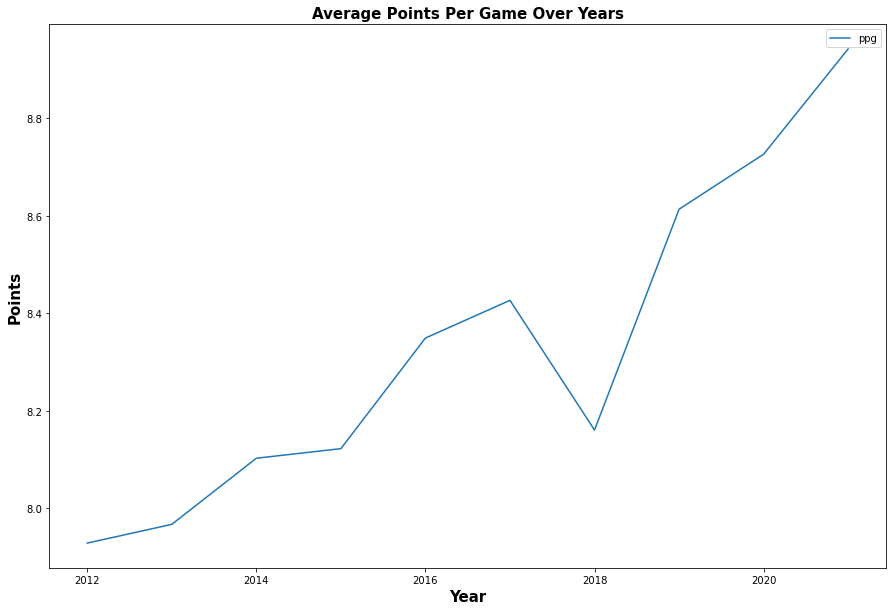

In [14]:
# In this function we will plot the PPG for all stars of the last 10 years
# Find the mean PPG over the last 10 years and graph as line graph


l = pd.DataFrame({'ppg': stat_avg("PTS")},
              index=years)
lines = l.plot.line(figsize=(15, 10))

plt.xlabel("Year", size = 15, weight = 'bold')
plt.ylabel("Points", size = 15, weight = 'bold')

plt.title("Average Points Per Game Over Years", size = 15, weight = 'bold')



From what we can see in the Average Points Per Game Over Years, their is an upward trend for average points per game over the years.

Text(0.5, 1.0, 'Average Value of All Stars Over Years')

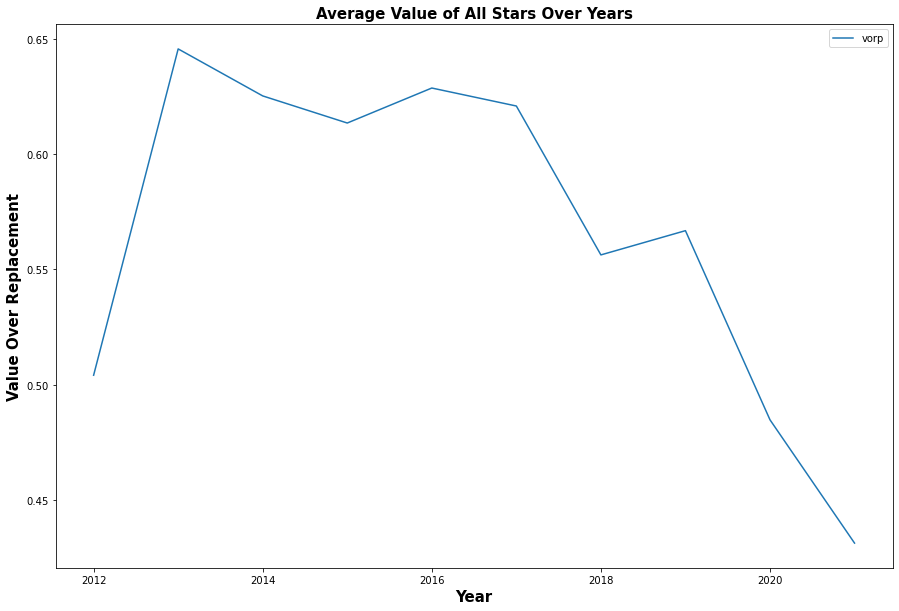

In [15]:
# In this function we will plot the VORP for all stars of the last 10 years

l = pd.DataFrame({'vorp': stat_avg("VORP")},
              index=years)
lines = l.plot.line(figsize=(15, 10))

plt.xlabel("Year", size = 15, weight = 'bold')
plt.ylabel("Value Over Replacement", size = 15, weight = 'bold')

plt.title("Average Value of All Stars Over Years", size = 15, weight = 'bold')

From what we can see in Average Player Efficient Rating of All Stars Over, the Per has increaswed over the pas few years with a slight spike in 2017, and still in on a rise.

Text(0.5, 1.0, 'Average Win Shares of All Stars Over Years')

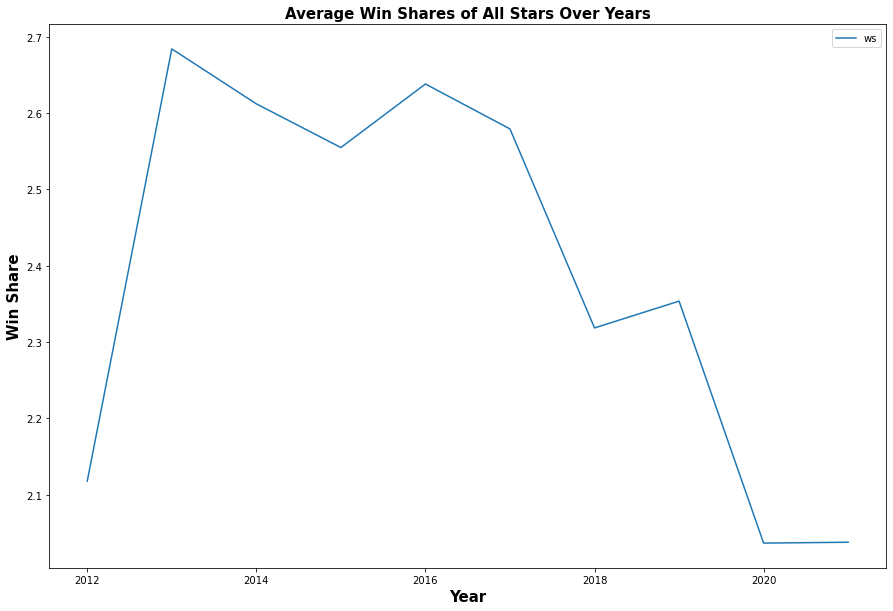

In [16]:
# In this function we will plot the WS for all stars of the last 10 years
l = pd.DataFrame({'ws': stat_avg("WS")},
              index=years)
lines = l.plot.line(figsize=(15, 10))

plt.xlabel("Year", size = 15, weight = 'bold')
plt.ylabel("Win Share", size = 15, weight = 'bold')

plt.title("Average Win Shares of All Stars Over Years", size = 15, weight = 'bold')

Regarding the Average Win Shares, from 2012 it goes on a steady rise, plateau around 2015,  rrises again and steadily drrops till 2020. The drop could be attributed to the lack of games played in the 2021 dataframe.

Text(0.5, 1.0, 'Average Box Plus/Minus of All Stars Over Years')

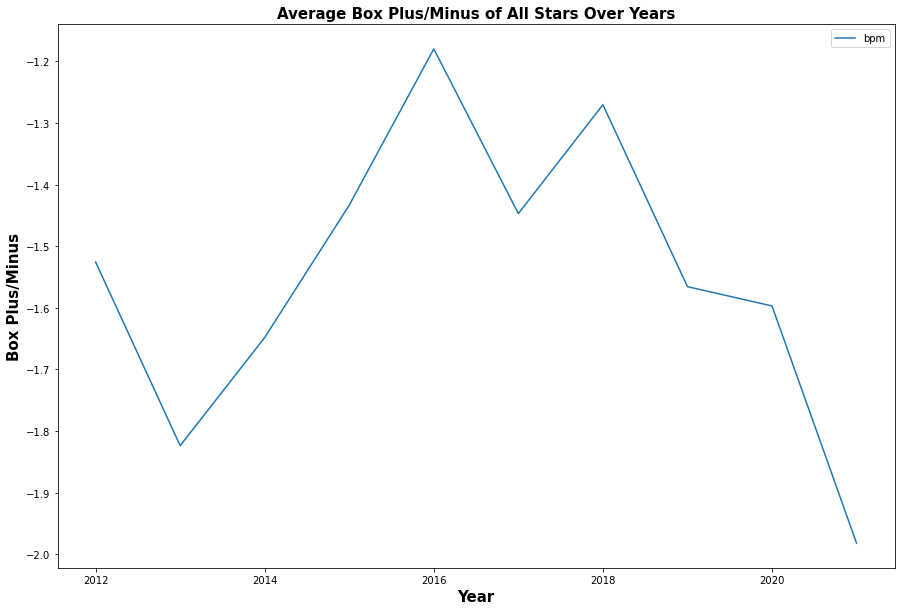

In [17]:
# In this function we will plot the BPM for all stars of the last 10 years
l = pd.DataFrame({'bpm': stat_avg("BPM")},
              index=years)
lines = l.plot.line(figsize=(15, 10))

plt.xlabel("Year", size = 15, weight = 'bold')
plt.ylabel("Box Plus/Minus", size = 15, weight = 'bold')

plt.title("Average Box Plus/Minus of All Stars Over Years", size = 15, weight = 'bold')

Regarding the Average Box Plus/Minus score over the years there is an upward trend from 2013 after a decline from 2012 for box plus/minus over the years.

In [18]:
all_star = df[df['Is All Star']==1]
not_all_star = df[df['Is All Star']==0]

<AxesSubplot:>

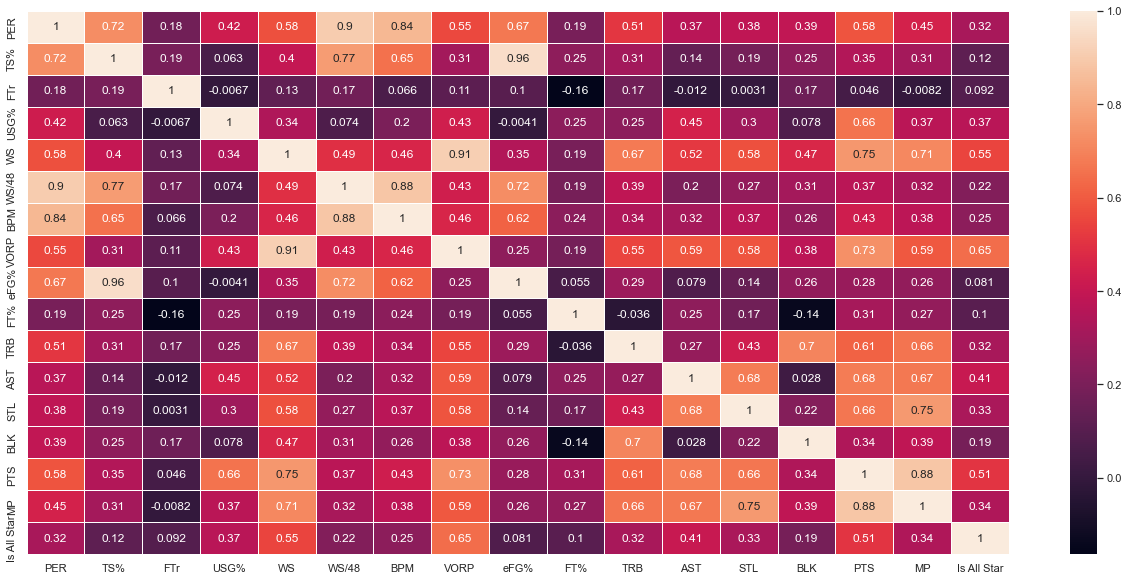

In [19]:
# visualise correlation matrix

temp_df = df
temp_df = temp_df.replace('', 0.0,regex=True)

df["PER"] = pd.to_numeric(df["PER"], downcast="float")
df["TS%"] = pd.to_numeric(df["TS%"], downcast="float")
df["FTr"] = pd.to_numeric(df["FTr"], downcast="float")
df["USG%"] = pd.to_numeric(df["USG%"], downcast="float")
df["WS"] = pd.to_numeric(df["WS"], downcast="float")
df["WS/48"] = pd.to_numeric(df["WS/48"], downcast="float")
df["BPM"] = pd.to_numeric(df["BPM"], downcast="float")
df["VORP"] = pd.to_numeric(df["VORP"], downcast="float")
df["eFG%"] = pd.to_numeric(df["eFG%"], downcast="float")
df["FT%"] = pd.to_numeric(df["FT%"], downcast="float")
df["TRB"] = pd.to_numeric(df["TRB"], downcast="float")
df["AST"] = pd.to_numeric(df["AST"], downcast="float")
df["STL"] = pd.to_numeric(df["STL"], downcast="float")
df["BLK"] = pd.to_numeric(df["BLK"], downcast="float")
df["PTS"] = pd.to_numeric(df["PTS"], downcast="float")
df["MP"] = pd.to_numeric(df["MP"], downcast="float")
df["Is All Star"] = pd.to_numeric(df["Is All Star"], downcast="float")



data = {'PER': df['PER'],
        'TS%': df['TS%'], 
        'FTr': df['FTr'],
        'USG%': df['USG%'],
        'WS': df['WS'],
        'WS/48': df['WS/48'],
        'BPM': df['BPM'],
        'VORP': df['VORP'],
        'eFG%': df['eFG%'],
        'FT%': df['FT%'],
        'TRB': df['TRB'],
        'AST': df['AST'],
        'STL': df['STL'],
        'BLK': df['BLK'],
        'PTS': df['PTS'],
        'MP': df['MP'],
        'Is All Star' : df['Is All Star']
    
        }

df = pd.DataFrame(data, columns=['PER','TS%', 'FTr', 'USG%', 'WS','WS/48','BPM','VORP','eFG%','FT%','TRB', 'AST', 'STL','BLK', 'PTS', 'MP', 'Is All Star'])


corrMatrix = df.corr()
sns.set(rc = {'figure.figsize':(22,10)})
sns.heatmap(corrMatrix, annot=True, linewidths=.5)


From our correlation matrix, we can see that WS/48, BPM, VORP, and TS% are the most important statistics for our prediction model. 

In [20]:
temp_df["PER"] = pd.to_numeric(temp_df["PER"], downcast="float")
temp_df["TS%"] = pd.to_numeric(temp_df["TS%"], downcast="float")
temp_df["FTr"] = pd.to_numeric(temp_df["FTr"], downcast="float")
temp_df["USG%"] = pd.to_numeric(temp_df["USG%"], downcast="float")
temp_df["WS"] = pd.to_numeric(temp_df["WS"], downcast="float")
temp_df["WS/48"] = pd.to_numeric(temp_df["WS/48"], downcast="float")
temp_df["BPM"] = pd.to_numeric(temp_df["BPM"], downcast="float")
temp_df["VORP"] = pd.to_numeric(temp_df["VORP"], downcast="float")
temp_df["eFG%"] = pd.to_numeric(temp_df["eFG%"], downcast="float")
temp_df["FT%"] = pd.to_numeric(temp_df["FT%"], downcast="float")
temp_df["TRB"] = pd.to_numeric(temp_df["TRB"], downcast="float")
temp_df["AST"] = pd.to_numeric(temp_df["AST"], downcast="float")
temp_df["STL"] = pd.to_numeric(temp_df["STL"], downcast="float")
temp_df["BLK"] = pd.to_numeric(temp_df["BLK"], downcast="float")
temp_df["PTS"] = pd.to_numeric(temp_df["PTS"], downcast="float")
temp_df["MP"] = pd.to_numeric(temp_df["MP"], downcast="float")


## Model Building
We will know write a function that shows us the most important statistics after testing each of our models. We use scikit-learn's brier_score_loss as that type of loss helps us predict players with the highest probabilities of making the 2022 All-Star Game. 

In [21]:
def model_builder(model, stats):
    train_acc = accuracy_score(model.predict(X_train[stats]), y_train)
    val_acc = accuracy_score(model.predict(X_val[stats]), y_val)
    
    t_loss = brier_score_loss(y_train, model.predict_proba(X_train[stats])[:, 1])
    v_loss = brier_score_loss(y_val, model.predict_proba(X_val[stats])[:, 1])
    
    print('\nTraining Accuracy: ' + str(train_acc),' Training Loss: '+ str(t_loss))
    print('\nValidation Accuracy: '+str(val_acc), 'Validation Loss: '+str(v_loss))
    

In [33]:
all_star_train, all_star_valid = sklearn.model_selection.train_test_split(all_star[all_star['Year']<=2021], test_size = 0.5)
non_all_star_train, non_all_star_valid = sklearn.model_selection.train_test_split(not_all_star[not_all_star['Year']<=2021], test_size = 0.5)

training = pd.concat([all_star_train, non_all_star_train], ignore_index=True).sample(frac=1)
validity = pd.concat([all_star_valid, non_all_star_valid], ignore_index=True).sample(frac=1)

test = temp_df[(temp_df.Year > 2020)]
training = training.replace('', 0.0)
validity = validity.replace('', 0.0)

## Hypothesis Test

In [34]:
stats = ['PER','TS%', 'FTr', 'USG%', 'WS','WS/48','BPM','VORP','eFG%','FT%','TRB', 'AST', 'STL','BLK', 'PTS', 'MP']

X_train = training[stats]
y_train = training["Is All Star"]

X_val = validity[stats]
y_val = validity["Is All Star"]
X_train = X_train.fillna(0.0)

X_train["PER"] = pd.to_numeric(X_train["PER"], downcast="float")
X_train["TS%"] = pd.to_numeric(X_train["TS%"], downcast="float")
X_train["FTr"] = pd.to_numeric(X_train["FTr"], downcast="float")
X_train["USG%"] = pd.to_numeric(X_train["USG%"], downcast="float")
X_train["WS"] = pd.to_numeric(X_train["WS"], downcast="float")
X_train["WS/48"] = pd.to_numeric(X_train["WS/48"], downcast="float")
X_train["BPM"] = pd.to_numeric(X_train["BPM"], downcast="float")
X_train["VORP"] = pd.to_numeric(X_train["VORP"], downcast="float")
X_train["eFG%"] = pd.to_numeric(X_train["eFG%"], downcast="float")
X_train["FT%"] = pd.to_numeric(X_train["FT%"], downcast="float")
X_train["TRB"] = pd.to_numeric(X_train["TRB"], downcast="float")
X_train["AST"] = pd.to_numeric(X_train["AST"], downcast="float")
X_train["STL"] = pd.to_numeric(X_train["STL"], downcast="float")
X_train["BLK"] = pd.to_numeric(X_train["BLK"], downcast="float")
X_train["PTS"] = pd.to_numeric(X_train["PTS"], downcast="float")
X_train["MP"] = pd.to_numeric(X_train["MP"], downcast="float")

In [35]:
min_loss = 1
selector_best = None


for i in range(1, len(stats)):
    selector = RFE(estimator = LogisticRegression(max_iter=150), n_features_to_select=i)

    rfe_pipe = make_pipeline(StandardScaler(), selector)
    
    rfe_pipe.fit(X_train[stats], y_train)
    loss = brier_score_loss(y_val, rfe_pipe.predict_proba(X_val)[:, 1])
    
    if loss < min_loss:
        min_loss = loss
        selector_best = clone(selector)

rfe_pipe = make_pipeline(StandardScaler(), selector_best)

rfe_pipe.fit(X_train, y_train)
rfe_support = selector_best.get_support()
rfe_features = X_train.loc[:, rfe_support].columns

print(str(len(rfe_features)), 'best features according to RFE:')
print(rfe_features.tolist())
model_builder(rfe_pipe, stats)

13 best features according to RFE:
['PER', 'TS%', 'USG%', 'WS', 'WS/48', 'VORP', 'eFG%', 'FT%', 'TRB', 'AST', 'BLK', 'PTS', 'MP']

Training Accuracy: 0.9768832204065365  Training Loss: 0.017010862131027676

Validation Accuracy: 0.9765033851055357 Validation Loss: 0.01652568989368994


In [36]:
log_reg = LogisticRegression()
logreg_pipe = make_pipeline(StandardScaler(), log_reg)
logreg_pipe.fit(X_train[rfe_features], y_train)

pd.DataFrame({"Coefs": log_reg.coef_.reshape((-1))}, index=rfe_features)

,Coefs
PER,-1.495861
TS%,-0.471586
USG%,1.015962
WS,0.868906
WS/48,1.049721
VORP,0.261917
eFG%,0.095416
FT%,0.218654
TRB,0.604788
AST,0.508561


3 best features according to SelectFromModel:
['WS', 'VORP', 'PTS']

Training Accuracy: 0.9912315663611  Training Loss: 0.008357353307714033

Validation Accuracy: 0.9757068896853843 Validation Loss: 0.01699792003194744


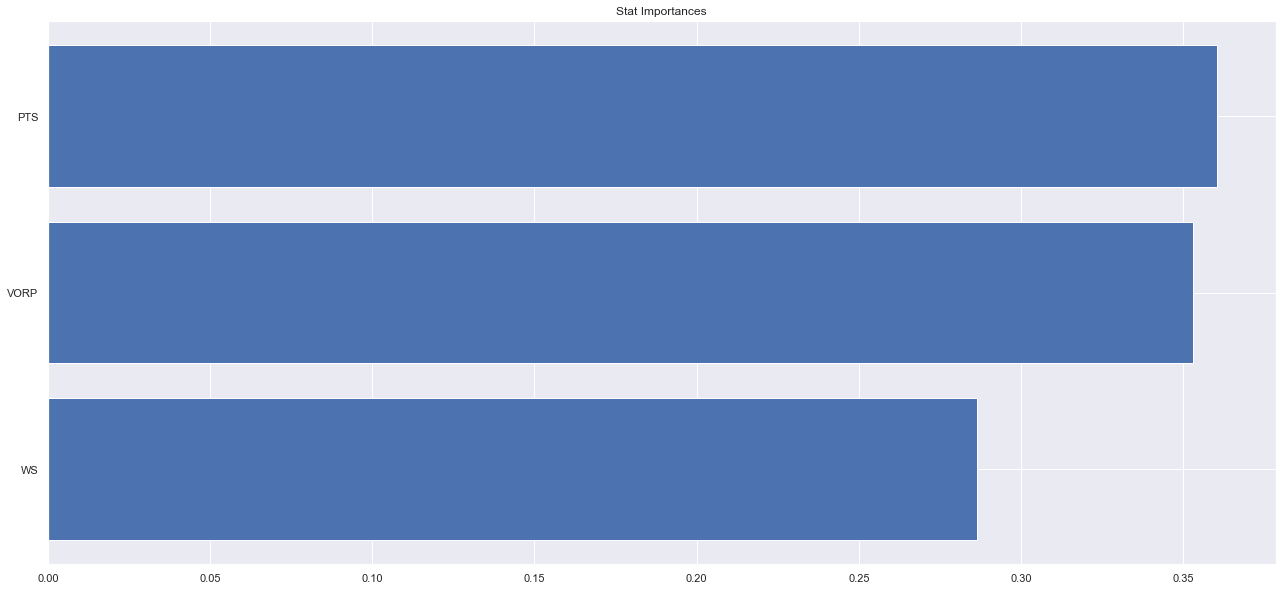

In [37]:
min_loss = 1
selector_best = None

for i in range(1, len(stats)):
    rf = RandomForestClassifier(max_depth=7,
                                random_state=7, oob_score=False)
    
    rf_selector = SelectFromModel(rf, max_features=i)
    rf_selector.fit(X_train, y_train)
    
    rf_support = rf_selector.get_support()
    rf_features = X_train.loc[:, rf_support].columns

    rf.fit(X_train[rf_features], y_train)
    
    loss = brier_score_loss(y_val, rf.predict_proba(X_val[rf_features])[:, 1])
    
    if loss < min_loss:
        min_loss = loss
        best_features = rf_features


rf_features = best_features
rf.fit(X_train[rf_features], y_train)

print(str(len(rf_features)), 'best features according to SelectFromModel:')
print(rf_features.tolist())
model_builder(rf, rf_features)

index = np.argsort(rf.feature_importances_)
features = X_train.columns[index]
plt.barh(width=rf.feature_importances_[index], y=best_features);
plt.title("Stat Importances");

In [38]:
X_test = test[features]
y_test = test["Is All Star"].astype(int)

def test_model(model, features):
    proba = model.predict_proba(test[features])[:, 1]
    pred = (proba > 0.65).astype(int)
    
    acc = accuracy_score(y_test, pred)
    loss = brier_score_loss(y_test, proba)
    
    return proba, pred
  
df = training.append(validity, ignore_index = True)

X, y = df.drop("Is All Star", axis=1), df["Is All Star"]

logreg_pipe.fit(X[rfe_features], y);
rf.fit(X[rf_features], y);

logreg_test = test_model(logreg_pipe, rfe_features)
rf_test = test_model(rf, best_features)

print("Logistic Regression Model: \n", sep="")
test_probability_lr = logreg_test[0]
test_prediction_lr = test_probability_lr > 0.65

acc_logreg = accuracy_score(y_test, test_prediction_lr)
loss_logreg = brier_score_loss(y_test, test_probability_lr)

print('Accuracy: \n'+str(acc_logreg)+ '\n Loss: \n'+str(loss_logreg))

print("\nRandom Forest Classifier: \n", sep="")
test_probability_rf = rf_test[0]
test_prediction_rf = test_probability_rf > 0.65

acc_rf = accuracy_score(y_test, test_prediction_rf)
loss_rf = brier_score_loss(y_test, test_probability_rf)

print('Accuracy: \n'+str(acc_rf)+ '\n Loss: \n'+str(loss_rf))

Logistic Regression Model: 

Accuracy: 
0.9777777777777777
 Loss: 
0.013543659792650629

Random Forest Classifier: 

Accuracy: 
0.9888888888888889
 Loss: 
0.00719861314302389


## Logistic Regression


In [39]:
basic2022 =  scrape_basic_stats(2022)
advanced2022 = scrape_advanced_stats(2022)

final2022 = pd.concat([basic2022,advanced2022], axis = 1)


In [40]:

y_pred_proba = []

for i in enumerate(logreg_test[0]):
    y_pred_proba.append(i[1])
y_pred_proba = np.asarray(y_pred_proba)

results_all_star = pd.DataFrame({
    "Player": test["Player"],
    "all_star_probability": y_pred_proba
    })

all_star_chances = test[['Player', 'Year']]
all_star_results = results_all_star.merge(all_star_chances, on='Player').sort_values(by='all_star_probability', ascending=False)

In [41]:
all_star_results.head(24)

,Player,all_star_probability,Year
262,Nikola Jokić,0.997528,2021
11,Giannis Antetokounmpo,0.967343,2021
129,Luka Dončić,0.967121,2021
115,Stephen Curry,0.945080,2021
296,Damian Lillard,0.931932,2021
420,Julius Randle,0.900711,2021
145,Joel Embiid,0.861287,2021
200,James Harden,0.858381,2021
516,Russell Westbrook,0.804602,2021
537,Trae Young,0.765062,2021


## Conclusion

In conclusion, we scraped data from basketball reference and stored it in several dataframes. We then were able to use a correlation matrix to determine which statistics were the most important in becoming an All-Star. After plotting out heat map we came to the conclusion that WS/48, BPM, VORP, and TS% are the most important statistics. With this information we created our predictive model and then performed logistic regression based on the validation model. We were able to predict all stars for 2022 with a high accuracy. Obviously it is imposssible to create a model that can  predict the 2022 All-Star team with 100% accuracy due to factors such as fan voting.

## Glossary 
**PER** - Player Efficiency Rating (available since the 1951-52 season); PER is a rating developed by ESPN.com columnist John Hollinger. In John's words, "The PER sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance." Please see the article Calculating PER for more information.

**TS%** - True Shooting Percentage; the formula is PTS / (2 * TSA). True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.

**ORB%** - Offensive Rebound Percentage (available since the 1970-71 season in the NBA); the formula is 100 * (ORB * (Tm MP / 5)) / (MP * (Tm ORB + Opp DRB)). Offensive rebound percentage is an estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor.

**DRB%** - Defensive Rebound Percentage (available since the 1970-71 season in the NBA); the formula is 100 * (DRB * (Tm MP / 5)) / (MP * (Tm DRB + Opp ORB)). Defensive rebound percentage is an estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor.

**TRB%** - Total Rebound Percentage (available since the 1970-71 season in the NBA); the formula is 100 * (TRB * (Tm MP / 5)) / (MP * (Tm TRB + Opp TRB)). Total rebound percentage is an estimate of the percentage of available rebounds a player grabbed while he was on the floor.

**USG%** - Usage Percentage (available since the 1977-78 season in the NBA); the formula is 100 * ((FGA + 0.44 * FTA + TOV) * (Tm MP / 5)) / (MP * (Tm FGA + 0.44 * Tm FTA + Tm TOV)). Usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor.

**BPM** - Box Plus/Minus (available since the 1973-74 season in the NBA); a box score estimate of the points per 100 possessions that a player contributed above a league-average player, translated to an average team. 

**VORP** - Value Over Replacement Player (available since the 1973-74 season in the NBA); a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season. Multiply by 2.70 to convert to wins over replacement. 

**DWS**- Defensive Win Shares.

**OWS** - Offensive Win Shares.